In [54]:
import pandas as pd, numpy as np, glob
from Bio.Seq import Seq

from matplotlib import pyplot as plt

import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

def makeorf(df,fill='.'):
    ref = Seq(''.join(df[(df.Ref!='.')]['Ref'].tolist()))
    alt = Seq(''.join(df[(df.Alt!='.')]['Alt'].tolist()))
    
    if df.Strand.min() < 0:
        ref = ref.reverse_complement()
        alt = alt.reverse_complement()
        
    return ref,alt

In [55]:
%matplotlib inline

## Bring in chrommap
chrommap = pd.read_csv('../DATA/chrommap.csv.gz')
chrommap['Seqid'] = chrommap['Contig']
chrommap['Chromosome'] = chrommap.index+1

In [56]:
## Bring in GFF file
gffpath = '../DATA/xl280genome.gff3.csv.gz'
gff = pd.read_csv(gffpath,index_col=0)

descriptions = ['hypothetical protein',
                'unspecified product',
                'conserved hypothetical protein']
foi = ['gene','three_prime_UTR','five_prime_UTR','CDS']


gff.columns = [c.capitalize() for c in gff.columns]

gff['Seqid'] = gff['Contig']
gff['Strand'] = gff['Strand'].replace(dict(zip(['-','+'],[-1,1])))
gff['Parent'] = [a.split('Parent=')[-1].split(';')[0].split('ID=')[-1] 
                 for a in gff.Attribute ]

genes = gff[(gff.Type=='gene')].sort_values('Start').copy()

genes['Description'] = [a.split('description=')[-1].split('%2C')[0] 
                        for a in genes.Attribute]

genes.head()

,Type,Gene,Start,End,Strand,Contig,Phase,Attribute,Description,Id,Seqid,Parent
4012,gene,CNE00010,38,910,-1,Chr05,.,ID=CNE00010;description=hypothetical protein,hypothetical protein,CNE00010,Chr05,CNE00010
67409,gene,CNH03875,76,2412,-1,Chr08,.,ID=CNH03875;description=hypothetical protein,hypothetical protein,CNH03875,Chr08,CNH03875
34312,gene,CNJ00010,171,4804,1,Chr10,.,ID=CNJ00010;description=conserved hypothetical...,conserved hypothetical protein,CNJ00010,Chr10,CNJ00010
70098,gene,CNG00010,196,1723,1,Chr07,.,ID=CNG00010;description=hypothetical protein,hypothetical protein,CNG00010,Chr07,CNG00010
70249,gene,CNH03660,211,2748,-1,Chr12,.,ID=CNH03660;description=alpha-amylase AmyA%2C ...,alpha-amylase AmyA,CNH03660,Chr12,CNH03660


In [57]:
samplespath = sorted(glob.glob('../DATA/GENOTYPE/GENES/*/*.csv.gz'))
samplespath[:5],len(samplespath)

(['../DATA/GENOTYPE/GENES/SS-A837/CNB02870-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB02995-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB03000-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB03005-t26_1.csv.gz',
  '../DATA/GENOTYPE/GENES/SS-A837/CNB03010-t26_1.csv.gz'],
 184)

In [58]:
todf = []
for s in samplespath:

    sample = s.split('GENES/')[-1].split('/')[0]
    genep = s.split('/')[-1].split('.csv')[0]
    gene_name = s.split('/')[-1].split('-t26')[0]

    temp = pd.read_csv(s,index_col=0)
    gene = temp.Gene.min()
    assert sample == temp.Sample.min()
    assert gene == genep
        
    cds = temp[(temp.Type==0)]
        
    ref,alt = makeorf(cds)
        
    el = cds.Pos.unique().shape[0]/3-1
        
    ra = ref.translate(to_stop=True)
    aa = alt.translate(to_stop=True)
        
    rl = len(ra)
    al = len(aa)
        
    sr = ref.translate().count('*')
    sa = alt.translate().count('*')
        
    ns = sa - 1
    for i in range(np.min([len(ra),len(aa)])):
        if ra[i]!=aa[i]:
            ns = ns + 1
            
    nvars = temp[(temp.Isvar==1)].shape[0]
    utr3 = temp[(temp.Type==3) & (temp.Isvar==1)].shape[0]
    utr5 = temp[(temp.Type==5) & (temp.Isvar==1)].shape[0]
    inexon = temp[(temp.Type==0) & (temp.Isvar==1)].shape[0]
    inintron = temp[(temp.Type==-1) & (temp.Isvar==1)].shape[0]


        
    todf.append((sample,gene_name,gene,
                 el,rl,al,sr,sa,ns,
                 nvars,utr5,utr3,inexon,inintron
                ))

In [59]:
resdf = pd.DataFrame(todf,
        columns=['Strain','Gene','Parent','Expected',
                 'Ref','Alt','Refstop','Altstop','Nonsyn',
                 'Nvars','Utr5','Utr3','Exon','Intron'
                ])
resdf.tail()

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron
179,XL280a,CNN01320,CNN01320-t26_1,215.0,215,215,1,1,0,77,5,51,9,12
180,XL280a,CNN01330,CNN01330-t26_1,71.0,71,71,1,1,0,10,0,1,0,9
181,XL280a,CNN01340,CNN01340-t26_1,406.0,406,406,1,1,0,25,0,5,19,1
182,XL280a,CNN01345,CNN01345-t26_1,188.0,188,188,1,1,0,27,1,1,6,19
183,XL280a,CNN01350,CNN01350-t26_1,260.0,260,260,1,1,0,16,1,10,3,2


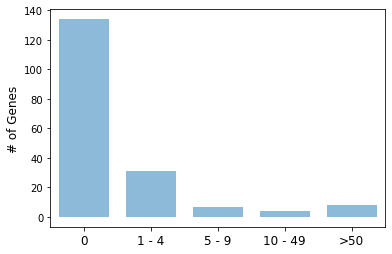

In [84]:
bins = [(0,1),(1,5),(5,10),(10,50),(50,1000)]

bin_counts = [resdf[(resdf.Nonsyn.isin(np.arange(*b)))].shape[0] for b in bins]
plt.vlines(np.arange(len(bins)),
           np.zeros(len(bin_counts)),
           bin_counts,linewidth=50,alpha=0.5)

binlabels = ['0']+[ ' - '.join([str(b) 
             for b in np.array(mybin)-np.array([0,1])]) 
             for mybin in bins][1:-1] + ['>50']

plt.xlim(-0.5,4.5)
plt.ylabel('# of Genes',fontsize=12);
plt.xticks(np.arange(len(bins)),binlabels,fontsize=12);

In [6]:
resdf[(resdf.Utr5>0)].shape

(98, 14)

In [7]:
resdf[(resdf.Utr3>0)].shape

(114, 14)

In [8]:
resdf.shape

(184, 14)

In [9]:
resdf[(resdf.Altstop==0)].shape

(1, 14)

In [10]:
resdf[(resdf.Altstop>1)].shape

(4, 14)

In [11]:
resdf[(resdf.Refstop==0)].shape

(0, 14)

In [12]:
resdf[(resdf.Refstop>1)].shape

(2, 14)

In [13]:
toredo = resdf[(resdf.Expected!=resdf.Ref)]
toredo.shape

(2, 14)

In [22]:
toredo

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron
83,SS-A837,CNN01270,CNN01270-t26_1,691.0,456,691,2,0,223,28,2,1,23,2
175,XL280a,CNN01270,CNN01270-t26_1,691.0,456,456,2,2,1,28,2,1,23,2


In [14]:
resdf.Strain.unique().shape

(2,)

In [15]:
## Genes with stop gains within them
sorted(resdf[(resdf.Altstop>1)].Gene.unique())[:5]

['CNB03090', 'CNK00230', 'CNK00260', 'CNN01270']

In [85]:
## CNF02550 hypothetical 
ssk1_name = 'CNB03090'
resdf[(resdf.Gene==ssk1_name)]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron
11,SS-A837,CNB03090,CNB03090-t26_1,1337.0,1337,157,1,64,75,38,0,0,37,1
103,XL280a,CNB03090,CNB03090-t26_1,1337.0,1337,1337,1,1,0,37,0,0,36,1


In [17]:
ric8_name = 'CNN01270'
resdf[(resdf.Gene==ric8_name)]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron
83,SS-A837,CNN01270,CNN01270-t26_1,691.0,456,691,2,0,223,28,2,1,23,2
175,XL280a,CNN01270,CNN01270-t26_1,691.0,456,456,2,2,1,28,2,1,23,2


In [87]:
ric8path = '../DATA/GENOTYPE/GENES/SS-A837/CNN01270-t26_1.csv.gz'
ric8 = pd.read_csv(ric8path,index_col=0)
ric8.head()

,Pos,Ref,Alt,Isvar,Strand,Type,Phase,Gene,Sample
0,386835,A,A,0,1,5,-1,CNN01270-t26_1,SS-A837
1,386836,A,A,0,1,5,-1,CNN01270-t26_1,SS-A837
2,386837,G,G,0,1,5,-1,CNN01270-t26_1,SS-A837
3,386838,T,T,0,1,5,-1,CNN01270-t26_1,SS-A837
4,386839,A,A,0,1,5,-1,CNN01270-t26_1,SS-A837


In [88]:
ric8[(ric8.Type==0)].head()

,Pos,Ref,Alt,Isvar,Strand,Type,Phase,Gene,Sample
322,387157,A,A,0,1,0,0,CNN01270-t26_1,SS-A837
323,387158,T,T,0,1,0,0,CNN01270-t26_1,SS-A837
324,387159,G,G,0,1,0,0,CNN01270-t26_1,SS-A837
325,387160,T,T,0,1,0,0,CNN01270-t26_1,SS-A837
326,387161,C,C,0,1,0,0,CNN01270-t26_1,SS-A837


In [89]:
ric8[(ric8.Type==0) & (ric8)]

,Pos,Ref,Alt,Isvar,Strand,Type,Phase,Gene,Sample
2712,389547,G,G,0,1,0,2,CNN01270-t26_1,SS-A837
2713,389548,G,G,0,1,0,2,CNN01270-t26_1,SS-A837
26,389549,T,C,1,1,0,2,CNN01270-t26_1,SS-A837
2715,389550,A,A,0,1,0,2,CNN01270-t26_1,SS-A837
2716,389551,G,G,0,1,0,2,CNN01270-t26_1,SS-A837


In [ ]:
ric8[(ric8.)]

In [ ]:
ric8.tail()

In [ ]:
finalres = resdf.merge(genes[['Gene','Chromosome','Seqid',
                   'Start','End','Strand','Description']])

In [ ]:
finalres.head()

In [ ]:
altstoped = finalres[(finalres.Altstop>1)]
altstoped.shape

In [ ]:
altstoped

In [ ]:
finalres.to_csv('../DATA/gene_changes.csv.gz',index=None)
finalres.shape

In [ ]:
#test = pd.read_csv('../DATA/OLD/gene_changes.csv.gz')
#test.shape

In [ ]:
#test[(test.Strain=='Stock6') & (test.Altstop>1)]

In [ ]:
#test[(test.Strain=='CF830') & (resdf.Altstop>1)]

In [ ]:
#test[(test.Gene==ric8_name)]

In [ ]:
#a1 = pd.read_csv('../GENES/B3502_A1_Stock1/CNN01270-t26_1.csv.gz',
#                 index_col=0)
#a1[(a1.Isvar==1)]

In [ ]:
#d1 = pd.read_csv('../GENES/B3502_D1_Stock6/CNN01270-t26_1.csv.gz',
#                 index_col=0)
#d1[(d1.Isvar==1)]